# LTA Overview  

In [2]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import itertools
from matplotlib.lines import Line2D

from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.visualization.wcsaxes import SphericalCircle

## Roadmap

**Current version: 0**

Version 0 :
- [x] Split HBA LBA, project, debug mode: include verification checks
- [x] TBD: add A-team sources location on the skymap view; add warning for filtering out the WTG-verification-DMO
- [x] Add iteration over markers or colours for each prjoect

Version 1 (Friday 21/01/22):
- [x] Include exposures -filter in plot function for exposure range, default all 
- [ ] Fermi gamma ray map (can't find)
- [x] Circle for A-team and make optional
- [x] Clickable markers - proj, SASID, antenna, ant filter
- [ ] Make background optional
- [ ] add 2MASS and TGSS https://irsa.ipac.caltech.edu/Missions/2mass.html https://vo.astron.nl/tgssadr/q_fits/imgs/form
- [ ] implement on notebook

Version 2:
- [ ] 90% Time and smearing
- [ ] lb data sets (output) (low prio)
---
Other Notes:
- Reevaluate the usefulness of the to_keep list, is this not similar/or made redundant with the plotprojects specification of the plot_overview function ?
- Filtering unique ra and dec and antenna is temp, later will take into account 
- Will eventually run with Julich data (will require extra input param) and add if project/data is in both datbases

Notes from 12/01:
- clickable markers
- interactive!



## Functions

### Prep

In [3]:
def split_saps(x):
    try:
        return x.split(",")
    except AttributeError:
        return None
        
def df_prep(datafile, to_keep, Debug = False):
    """
    Get relevant info for a selected list of projects as a new dataframe.
    
    Parameters
    ----------
    datafile : str
        The filename of the input database (i.e. with standardazed header structure)
    to_keep : list
        The list of projects to be selected for plotting
    Debug: bool, optional
        Print auxiliary info for verifications
    
    Returns
    -------
    result : dataframe
        Dataframe with the subset of info relevant for the seected projects
    """
    df_og = pd.read_csv(datafile, delimiter="\t", dtype ={'SAPS': str})
    df = df_og.copy()
#   df = df.drop(['SUCCESSOR_MOM_ID', 'SUCCESSOR_SAS_ID', 'SUCCESSOR_TYPE', 'STORAGE_MANAGER', 
#                           'SPACE_USED', 'Size dysco compr [TB]', 
#                           'Expected compression time if LBA per subband', 
#                           'Expected compression time if HBA per subband',
#                           'Expected compression time per dataset' ], axis = 1)
    if Debug: 
        print(f"Length of original df: {len(df.index)}")
    df = df[df["PROJECT"].isin(to_keep)]
    
    if Debug: 
        print(f"Length using only projects in column G: {len(df.index)}")
        
    # A special case is represented by the project WTG-verification-DMO, for which main info is not available !
    if 'WTG-verification-DMO' in to_keep:
        print("WARNING project 'WTG-verification-DMO' is unavailable for plotting and has been automatically discarded from plots and dataframes.")
    df = df[df["PROJECT"] != 'WTG-verification-DMO']
    
    df = df.replace({'DEC': '0'}, '0,0')
    
    df['SAPS'] = df.SAPS.apply(lambda x: split_saps(x))
    
    #remove trailing commas
    df["RA"] = df.apply(lambda x: x.RA if x.RA[-1] != ',' else x.RA[:-1], axis = 1)
    df["DEC"] = df.apply(lambda x: x.DEC if x.DEC[-1] != ',' else x.DEC[:-1], axis = 1)
    
    #split observations with mulitple SAPS into list. Also need to deal with delimiter inconsistency ("," when alone, "." when in list of observations)
    df["RA"] = df.apply(lambda x: x.RA.split(',') if x.SAPS != ["0"] else [x.RA.replace(",", ".")], axis = 1)
    df["DEC"] = df.apply(lambda x: x.DEC.split(',') if x.SAPS != ["0"] else [x.DEC.replace(",", ".")], axis = 1)
   
    #remove weird extra 0s at the beginning of the RAs
    df["RA"] = df.apply(lambda x: x.RA if len(x.RA)==len(x.DEC) else x.RA[1:], axis = 1) 
    
    #correct the SAPS that have missmatched numbers of SAPS compared to coords
    # TO BE DONE: VERIFY THIS ASSUMPTION
    df["SAPS"] = df.apply(lambda x: len(x.RA)*[np.nan] if x.SAPS == None else [i for i in range(len(x.RA))], axis = 1) 


    # only exploded ra and dec as that is what is needed now but will probably have to come back
    # to this later if new info is required
    df = df.explode(["RA", "DEC", "SAPS"])
    df = df.reset_index(drop = True)
    
    return df

### Image 

In [6]:
def overview_image(df, outname, plotProject = 'all', plotAntenna = 'both', legend_ncols = 2, Debug = False, testMode = False, plotAteam = False, exp_range = [- np.inf, np.inf]): 
    """
    Plotting routine for a selected list of projects.
    
    Parameters
    ----------
    datafile : str
        The filename of the input database (i.e. with standardazed header structure)
    outname : str
        The prefix name for the generated outputs, e.g. plots
    plotProject : str
        The filter to select a subset of projects
    plotAntenna : str
        The filter for selecting and plottinf data of a specific antenna field
    legend_ncols : int
        The number of columns for the layout of the legend box
    Debug: bool, optional
        Print auxiliary info for verifications
    testMode : bool, optional
        Only limit the plotting to the first 100 datapoints
    plotAteam: bool, optional
        Plot the A team source circles with names, default False
    exp_range: list of ints, optional 
        first elemet is the minimum exposure in seconds and second is maximum exposure, default all exposures
    Returns
    -------
    result : plots
        Return specified plot
    """
    # cleanup Antenna column 
    df["ANTENNA"] = df.apply(lambda x: x.ANTENNA_SET[:3], axis =1)
    
    #filter out duplicates in project, ra, dec and antenna
    df = df.drop_duplicates(subset = ["PROJECT", "RA", "DEC", "ANTENNA"])
    df = df[df["MIN_EXPOSURE"] < exp_range[1]]
    df = df[df["MIN_EXPOSURE"] > exp_range[0]]
    
    if Debug:
        print(f'Length without duplicates in Proj, Coords, Antenna:{len(df.index)}')
        
    #warn user if WTG selected as this was filtered out in df_prep    
    if 'WTG-verification-DMO' in plotProject:
        print("WARNING project 'WTG-verification-DMO' is unavailable for plotting and has been automatically discarded from plots and dataframes.")
    
    #select only the projects that the user wants to plot creating new df "df_red"
    if plotProject == 'all':
        df_red = df
    else:
        #for 'all' keyword
        if isinstance(plotProject, str) and plotProject == 'all':
            plotProject = [plotProject]
            df_red = df[df["PROJECT"].isin(plotProject)]
            
        elif isinstance(plotProject, list):
            df_red = df[df["PROJECT"].isin(plotProject)]
        else:
            print("ERROR with plotProject input. Please use list of projects as strings or the 'all' keyword")
    
        if len(plotProject) != len(df_red["PROJECT"].unique()):
            print("!!! WARNING: Project list lengths differ, some projects may not be plotted. Please double check name and format. !!!")
            print(f"Length plotProject: {len(plotProject)}")
            print(f"Length of Projects to plot: {len(df_red['PROJECT'].unique())}")
    
    if Debug:
        print(f'Projects to plot: {df_red["PROJECT"].unique()}')
            
    #image stuff 
    image = 'lambda_mollweide_haslam408_nofilt.fits'
#     image = 'detthresh_P8R3_source_8years_PL22.fits'
    hdu = fits.open(image)[1]
    wcs = WCS(hdu.header)

    fig = plt.figure(figsize = (10, 10))
    fig.set_facecolor('white')

    ax = fig.add_subplot(projection = wcs, frame_class=EllipticalFrame)
    ax.imshow(hdu.data, vmin = 9e3, vmax = 1.5e5, cmap = 'hot')
    
    #hard code the A team sources in: [name, coords]
    A_team = [["Cas_A", "23h23m24s +58d48m54s"],
              ["Cyg_A", "19h59m28.3564s +40d44m02.096s"],
              ["Her_A", "16h51m08.024s +04d59m34.91s"],
              ["Tau_A", "05h34m31.94s +22d00m52.2s"],
              ["Ver_A", "12h30m49.4233s +12d23m28.043s"]]
    if plotAteam:
        for A_source in A_team:
            c = SkyCoord(A_source[1])
            pix = wcs.world_to_pixel(c.galactic)
#             ax.scatter(pix[0], pix[1], marker = '^', c = 'b', s = 20)
#             print(c.lon)
            sph = SphericalCircle((c.ra,c.dec), 4*u.deg, edgecolor = 'b', facecolor='none', linewidth = 1.5, transform= ax.get_transform('fk5'))
            ax.add_patch(sph)
            if A_source[0] == "Tau_A":
                ax.text(pix[0] - 280, pix[1] + 1, A_source[0], c = 'w')
            else:
                ax.text(pix[0] + 50, pix[1] + 1, A_source[0], c = 'w')

    
    #testmode to use a reduced number of points
    if testMode:
        df_to_run = df_red.iloc[:100]
    else:
        df_to_run = df_red
    
    #plot the points with appropirate transform and append proj name to the atenna lists. Later will use to 
    # specify what projects are what antennas and count amount of points plotted
    HBA_proj = []
    LBA_proj = []
    
#     markers = itertools.cycle(Line2D.markers)
    colours = itertools.cycle(get_cmap('tab20').colors)
    projs = df_to_run["PROJECT"].unique()
    for proj in projs:
        colour = next(colours)
        
        for index, row in df_to_run[df_to_run["PROJECT"] == proj].iterrows():
            #make sure ra and dec in correct format for SkyCoord
            ra = float(row["RA"]) * u.deg
            try:
                dec = float(row["DEC"]) * u.deg
            except ValueError:
                print(index)
            coords = SkyCoord(ra, dec, unit = u.deg, frame='icrs')

            #Plot only required antenna + append to list to know which antenna was used for label later (temporary: could maybe use df filtering?)
            if (row["ANTENNA"] == 'HBA') and ((plotAntenna == 'HBA') or (plotAntenna == 'both')):
#                 edgecolor = 'b'
                sph_r = 0.5 * 3*u.deg
                marker = "D"
                HBA_proj.append(row["PROJECT"])

                pix = wcs.world_to_pixel(coords.galactic)
                ax.scatter(pix[0], pix[1], marker = marker, color = colour, s = 20, label = row["PROJECT"])

            elif (row["ANTENNA"] == 'LBA') and ((plotAntenna == 'LBA') or (plotAntenna == 'both')):
#                 edgecolor = 'c'
                sph_r = 0.5 * 13*u.deg
                marker = "o"
                LBA_proj.append(row["PROJECT"])

                pix = wcs.world_to_pixel(coords.galactic)
                ax.scatter(pix[0], pix[1], marker = marker, color = colour, s = 20, label = row["PROJECT"])

    # shrink box by 20% to fit the legend outside the plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    #get and plot only the unique labels in the legend
    handles, labels = ax.get_legend_handles_labels()
    print(labels)
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    unique.sort(key = lambda x:x[1])

    
    total_numpoints = 0 #counter for number of plotted points
    #use a new list (unique2) to modify the legend labels
    unique2 = []
    for i in unique:
        lst = list(i)

        numpoints = HBA_proj.count(i[1]) + LBA_proj.count(i[1])
        total_numpoints += numpoints 

        if (i[1] in HBA_proj) and (i[1] in LBA_proj):
            lst[1] += f' #{numpoints} (HBA & LBA)'
        elif i[1] in HBA_proj:
            lst[1] += f' #{numpoints} (HBA)'
        elif i[1] in LBA_proj:
            lst[1] += f' #{numpoints} (LBA)'     
        else: 
            print(f'Errrrooorr: {i[1]}')

        unique2.append(tuple(lst))
    
    if Debug:    
        print(f"Total points plotted: {total_numpoints}")
    
    # Put a legend to the right of the current axis
    ax.legend(*zip(*unique2), loc='center left', bbox_to_anchor=(1.1, 0.5), ncol = legend_ncols)
    
    fig.suptitle(f"{outname}", y = 0.7)
    plt.subplots_adjust(top = 0.8)
    fig.savefig(f"{outname}.png", bbox_inches = 'tight')

## Raw data

WARNING project 'WTG-verification-DMO' is unavailable for plotting and has been automatically discarded from plots and dataframes.
['LC2_036', 'LC2_036', 'LC2_036', 'LC2_036', 'LC2_036', 'DDT3_003', 'LC3_012', 'LC4_016', 'LC4_016', 'DDT4_002', 'DDT4_002', 'DDT4_003', 'DDT4_003', 'DDT4_003', 'DDT001', 'DDT001', 'DDT001', 'LC6_018', 'LC8_033', 'LC8_033', 'LC9_002', 'LC9_002', 'LC9_002', 'LC0_032', 'LC0_032', 'LC0_032', 'LC0_032', 'LC0_032', 'LC0_032', 'LC0_015', 'LC0_015', 'LC0_015', 'LC0_012', 'LC0_012', 'LC0_012', 'LC0_012', 'LC0_012', 'LC0_012', 'LC0_012', 'LC0_012', 'LC0_039', 'LC0_039', 'LC0_039', 'LC0_039', 'LC0_039', 'LC0_039', 'LC0_039', 'LC0_039', 'LC0_039', 'LC0_039', 'LC0_039', 'LC0_039', 'LC0_024', 'LC0_020', 'LC0_003', 'LC0_003', 'LC0_003', 'LC0_003', 'LC0_041', 'LC0_041', 'LC1_038', 'LC1_038', 'LC1_038', 'DDT1_002', 'DDT2_001']


Index(['MOM_ID', 'SAS_ID', 'PROJECT', 'OBSERVATION_TYPE', 'SUCCESSOR_MOM_ID',
       'SUCCESSOR_SAS_ID', 'SUCCESSOR_TYPE', 'STORAGE_MANAGER', 'SPACE_USED',
       'RA', 'DEC', 'SAPS', 'CHANNELWIDTH', 'CLOCK', 'TIME_RES',
       'MAX_EXPOSURE', 'MIN_EXPOSURE', 'ANTENNA_SET', 'NR_STATIONS',
       'NR_INT_STATIONS', 'NR_CORRELATED', 'Size dysco compr [TB]',
       'Expected compression time if LBA per subband',
       'Expected compression time if HBA per subband',
       'Expected compression time per dataset', 'ANTENNA'],
      dtype='object')

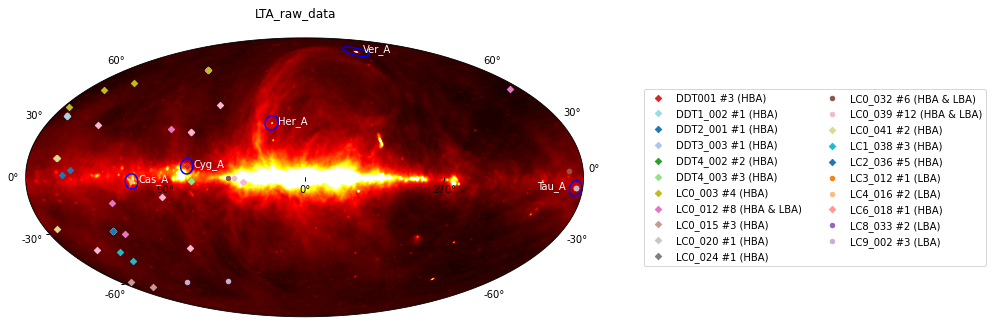

In [8]:
Debug = False
testMode = False

#cp from column G of summary sheet
to_keep_raw = 'WTG-verification-DMO','DDT001','DDT002','DDT1_002','DDT2_001','DDT3_003','DDT4_002','DDT4_003','LC0_003','LC0_009','LC0_012','LC0_015','LC0_017','LC0_020','LC0_024','LC0_028','LC0_032','LC0_039','LC0_041','LC1_036','LC1_038','LC2_006','LC2_036','LC3_004','LC3_012','LC4_010','LC4_016','LC6_018','LC8_033','LC9_002'
# to_keep_raw = ["LC0_012"]
#run scripts
df_raw = df_prep('data/raw_data.tsv', to_keep_raw, Debug = Debug)
overview_image(df_raw, 'LTA_raw_data',plotProject ='all',plotAntenna = 'both', Debug = Debug, testMode = testMode, plotAteam=True, exp_range = [-np.inf, 14000])
# df_raw[df_raw['PROJECT'] == 'DDT001']['PROJECT'].unique()
df_raw.columns


## avg pip data no dysco

In [20]:
to_keep_avg_pip = 'DDT0007','DDT1_001','DDT1_002','DDT2_001','DDT3_003','DDT4_002','DDT4_003','DDT7_001','DDT9_001','DDT9_002','DDT9_005','DDT10_001','LC0_003','LC0_005','LC0_006','LC0_009','LC0_012','LC0_015','LC0_019','LC0_024','LC0_025','LC0_039','LC1_002','LC1_008','LC1_011','LC1_014','LC1_023','LC1_028','LC1_033','LC1_038','LC1_039','LC1_055','LC2_019','LC2_020','LC2_034','LC2_036','LC2_038','LC2_039','LC3_004','LC3_011','LC3_020','LC3_025','LC3_028','LC3_034','LC4_007','LC4_008','LC4_010','LC4_011','LC4_015','LC4_035','LC5_010','LC5_016','LC5_017','LC5_020','LC5_023','LC6_009','LC6_011','LC6_013','LC6_015','LC6_018','LC6_021','LC7_026','LC7_027','LC8_006','LC8_014','LC8_017','LC8_019','LC8_020','LC8_025','LC8_034','LC9_002','LC9_004','LC9_005','LC9_008','LC9_011','LC9_012','LC9_013','LC9_014','LC9_015','LC9_019','LC9_020','LC9_027','LC9_035','LC10_010','LC10_013','LC12_012','LT5_006','LT5_009','LT10_003','LT10_010','LT10_013'

df_avg_pip = df_prep('data/avg_pip_data_no_dysco.tsv', to_keep_avg_pip)
overview_image(df_avg_pip, 'LTA_avg_pip', legend_ncols = 5)


KeyboardInterrupt: 

## cal pip data no dysco

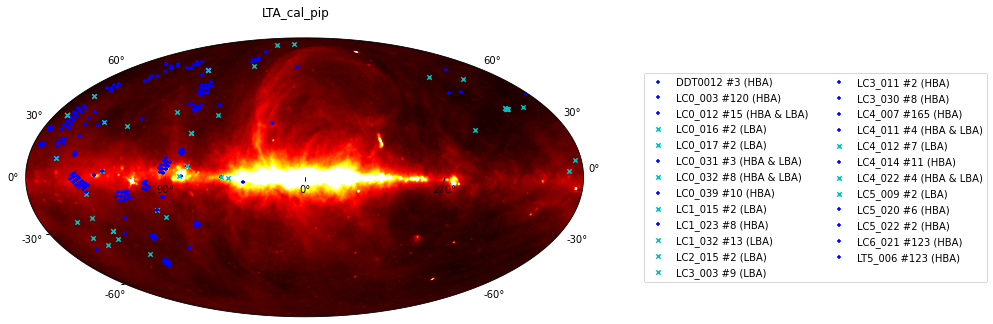

In [23]:
to_keep_cal_pip = 'DDT0012','LC0_003','LC0_012','LC0_016','LC0_017','LC0_031','LC0_032','LC0_039','LC1_015','LC1_023','LC1_032','LC2_015','LC3_003','LC3_011','LC3_030','LC4_007','LC4_011','LC4_012','LC4_014','LC4_022','LC5_009','LC5_020','LC5_022','LC6_021','LT5_006'
df_cal_pip = df_prep('data/cal_pip_data_no_dysco.tsv', to_keep_cal_pip)
overview_image(df_cal_pip, 'LTA_cal_pip')

## lb avg pip data + lb pip data

Linked with cal pip SASIDS, will need to create df from cal_pip df

In [ ]:
to_keep_lb = 'LC4_007','LC4_014','LC5_020','LC5_022','LC6_021','LT5_006'

## Testing with no filter on raw data

Original length: 7179
Only Projects in column G: 7179
raw_data
Original length: 17741
Without duplicates length:4318
Total numpoints = 4318


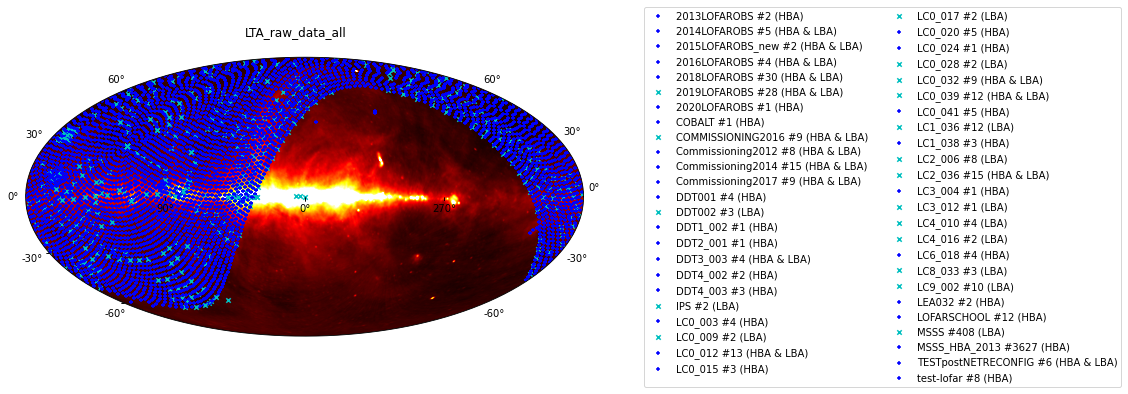

In [51]:
df_all = df_prep('data/raw_data.tsv', [])
print("raw_data")
overview_image(df_all, 'LTA_raw_data_all', testMode = False)

## Old stuff

In [ ]:
# Before made into a function

image = 'lambda_mollweide_haslam408_nofilt.fits'
# image  = get_pkg_data_filename('allsky/allsky_rosat.fits')
hdu = fits.open(image)[1]
# hdu.header["CTYPE1"] = 'GLON-CAR'
# hdu.header["CTYPE2"] = 'GLAT-CAR'

# data_sq = np.squeeze(hdu.data)
wcs = WCS(hdu.header)

fig = plt.figure(figsize = (10, 10))
fig.set_facecolor('white')

ax = fig.add_subplot(projection = wcs, frame_class=EllipticalFrame)
ax.imshow(hdu.data, vmin = 9e3, vmax = 1.5e5, cmap = 'hot')
# df.duplicated(subset=['brand'])
HBA_proj = []
LBA_proj = []
for index, row in raw_df.iterrows():
    ra = float(row["RA"]) * u.deg
    dec = float(row["DEC"]) * u.deg
    coords = SkyCoord(ra, dec, unit = u.deg, frame='icrs')
    
    if row["ANTENNA_SET"][:3] == 'HBA':
        edgecolor = 'b'
        sph_r = 0.5 * 3*u.deg
        marker = '+'
        HBA_proj.append(row["PROJECT"])
        
    else:
        edgecolor = 'c'
        sph_r = 0.5 * 13*u.deg
        marker = 'x'
        LBA_proj.append(row["PROJECT"])
#     print(coords.galactic.l)
#     if (abs(coords.galactic.l -180*u.deg) < sph_r) or (abs(coords.galactic.l -1*u.deg) < sph_r):
#         pix = wcs.world_to_pixel(coords.galactic)
#         ax.scatter(pix[0], pix[1], marker = '+', c = edgecolor, s = 50)
        
#     else:
#         sph_obs = SphericalCircle((ra, dec), sph_r, edgecolor = edgecolor, facecolor = 'none',
#                                   transform = ax.get_transform('icrs'), linewidth = 1)
#         ax.add_patch(sph_obs)
    pix = wcs.world_to_pixel(coords.galactic)
    ax.scatter(pix[0], pix[1], marker = marker, c = edgecolor, s = 20, label = row["PROJECT"])

# shrink box by 20% to fit the legend outside the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

#get and plot only the unique labels
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
unique.sort(key = lambda x:x[1])

unique2 = []
for i in unique:
    lst = list(i)
    
    if (i[1] in HBA_proj) and (i[1] in LBA_proj):
        lst[1] += ' (HBA & LBA)'
    elif i[1] in HBA_proj:
        lst[1] += ' (HBA)'
    elif i[1] in LBA_proj:
        lst[1] += ' (LBA)'     
    else: 
        print(f'Errrrooorr: {i[1]}')
   
    unique2.append(tuple(lst))

# Put a legend to the right of the current axis
ax.legend(*zip(*unique2), loc='center left', bbox_to_anchor=(1.1, 0.5), ncol = 3)
# fig.suptitle("LTA (SURFsara) overview of the raw data, where the blue markers are HBA observations and the cyan markers are LBA ones.")
fig.savefig("LTA_overview_plot.png")

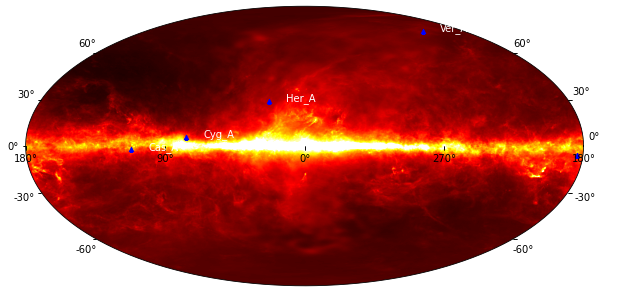

In [5]:
#     image = 'lambda_mollweide_haslam408_nofilt.fits'
image = 'detthresh_P8R3_source_8years_PL22.fits'
hdu = fits.open(image)[0]
wcs = WCS(hdu.header)

fig = plt.figure(figsize = (10, 10))
fig.set_facecolor('white')

ax = fig.add_subplot(projection = wcs, frame_class=EllipticalFrame)
ax.imshow(hdu.data, vmin = 9e-13, vmax = 5e-12, cmap = 'hot')

#hard code the A team sources in: [name, coords]
A_team = [["Cas_A", "23h23m24s +58d48m54s"],
          ["Cyg_A", "19h59m28.3564s +40d44m02.096s"],
          ["Her_A", "16h51m08.024s +04d59m34.91s"],
          ["Tau_A", "05h34m31.94s +22d00m52.2s"],
          ["Ver_A", "12h30m49.4233s +12d23m28.043s"]]
for A_source in A_team:
    c = SkyCoord(A_source[1])
    pix = wcs.world_to_pixel(c.galactic)
    ax.scatter(pix[0], pix[1], marker = '^', c = 'b', s = 20)
    ax.text(pix[0] + 30, pix[1] + 1, A_source[0], c = 'w')

In [12]:
# from matplotlib.backend_bases import MouseButton
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib


t = np.arange(0.0, 1.0, 0.01)
s = np.sin(2 * np.pi * t)
fig, ax = plt.subplots()
ax.plot(t, s)


def on_move(event):
    # get the x and y pixel coords
    x, y = event.x, event.y
    if event.inaxes:
        ax = event.inaxes  # the axes instance
        print('data coords %f %f' % (event.xdata, event.ydata))


def on_click(event):
    if event.button is MouseButton.LEFT:
        print('disconnecting callback')
        plt.disconnect(binding_id)


binding_id = plt.connect('motion_notify_event', on_move)
plt.connect('button_press_event', on_click)

plt.show()

<IPython.core.display.Javascript object>

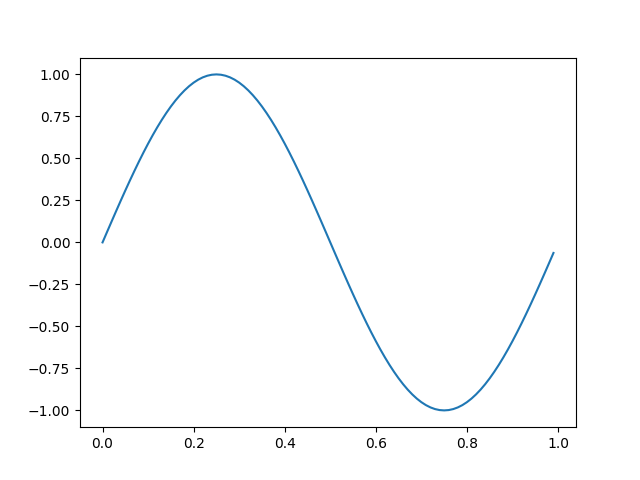

In [7]:
from matplotlib.backend_bases import MouseButton
import matplotlib.pyplot as plt
import numpy as np
# import matplotlib

# %matplotlib widget
t = np.arange(0.0, 1.0, 0.01)
s = np.sin(2 * np.pi * t)
fig, ax = plt.subplots()
ax.plot(t, s)


def on_move(event):
    # get the x and y pixel coords
    x, y = event.x, event.y
    if event.inaxes:
        ax = event.inaxes  # the axes instance
        print('data coords %f %f' % (event.xdata, event.ydata))


def on_click(event):
    if event.button is MouseButton.LEFT:
        print('disconnecting callback')
        plt.disconnect(binding_id)


# binding_id = plt.connect('motion_notify_event', on_move)
cid = fig.canvas.mpl_connect('button_press_event', on_click)
fig.canvas.mpl_disconnect(cid)
# plt.show()

In [43]:
a = np.array([1,2])

In [44]:
a.shape

(2,)